# Exploratory Data Analysis

The main objective of this notebook are:

* Explore the data by performing univariate analysis
* Investigate the relationship between features and target variable `fies` by performing bivariate and multivariate analysis
* Extract relavant insights from the dataset to share with stakeholders
* Understand the steps that will be required for ML pre-processing



**TASK**


- Engineer a new feature `any_production_difficulty`.
- Engineer a new feature `any_sales_difficulty`.
- Engineer a new feature `both_difficulty`.



* Subset the columns required for regression and transform to formats ready for modelling.

* **Key highlights**

* **Recommendations**
  - Short term
  - Long Term

## 1.0 Import Libraries and Packages

In [1]:
import sys
import os

import pandas as pd
import geopandas as gpd
from scipy.stats import ttest_ind
from scipy.stats import kruskal # statistical test for betweeen categorical and ordinal dependent variable
import numpy as np
from tableone import TableOne
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, FixedLocator
import seaborn as sns

# Path needs to be added manually to read from another folder
path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname('__file__'), os.path.pardir, 'utils')))
if (not (path2add in sys.path)) :
    sys.path.append(path2add)

from eda import (data_type_converter, 
                 compute_groupby, 
                 plot_grouped_data, 
                 calculate_groupby_percentage, 
                 plot_group_by_percentage,
                 )

# sns.set_theme(style="white")
sns.set_theme(style="white", palette="pastel")

In [2]:
# Load the dataset into the DataFrame
data = pd.read_csv("../data/fao_round6_ng_clean_data.csv")

## 2.0 **Discovering**

In [3]:
data.head()

,country,state,local_govt_area,hh_agricactivity,hh_gender,hh_education,hh_size,hh_maritalstat,hh_age,resp_islsproducer,...,fcs_staple_days,fcs_pulses_days,fcs_vegetables_days,fcs_fruit_days,fcs_meat_fish_days,fcs_dairy_days,fcs_sugar_days,fcs_oil_days,fcs_condiments_days,income_main_cat
0,Nigeria,Zamfara,Talata Mafara,crop production,Male,Religious Education,18.0,2.0,41 to 65,No,...,5.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,Public employment
1,Nigeria,Zamfara,Bukkuyum,crop and livestock production,Male,Primary Education,9.0,2.0,41 to 65,Yes,...,7.0,3.0,7.0,0.0,0.0,0.0,0.0,3.0,3.0,Non-Agricultural wage and employment
2,Nigeria,Zamfara,Bukkuyum,crop and livestock production,Male,Primary Education,19.0,2.0,41 to 65,Yes,...,7.0,3.0,3.0,3.0,0.0,1.0,3.0,2.0,3.0,Production and sale of Ag produce
3,Nigeria,Zamfara,Talata Mafara,crop production,Male,Religious Education,14.0,2.0,41 to 65,No,...,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,Production and sale of Ag produce
4,Nigeria,Zamfara,Talata Mafara,crop production,Male,Higher Education,12.0,2.0,41 to 65,No,...,7.0,3.0,4.0,0.0,2.0,0.0,0.0,7.0,0.0,Production and sale of Ag produce


In [4]:
data.shape

(3438, 158)

In [5]:
### Distribution of the data by state
state_counts = data["state"].value_counts(normalize=True)*100
state_counts

state
Zamfara    77.923211
Borno       6.311809
Katsina     5.410122
Adamawa     5.235602
Yobe        5.119255
Name: proportion, dtype: float64

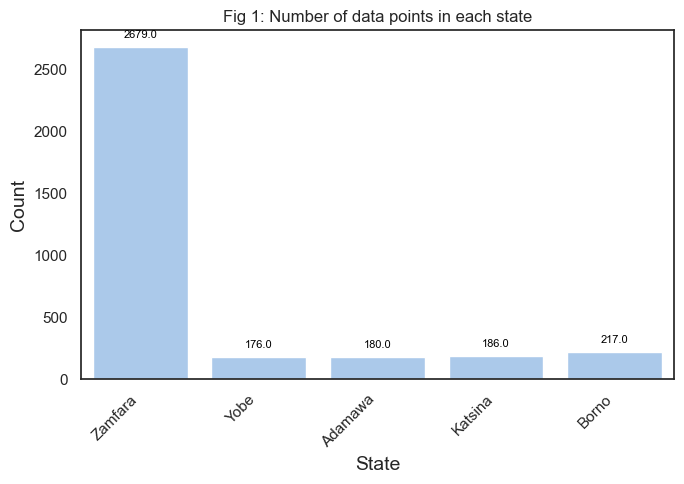

In [6]:
# Plot of the data distribution
plt.figure(figsize=(7,5))


ax = sns.countplot(data = data, x="state", orient="h")

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.xlabel('State', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.title("Fig 1: Number of data points in each state")
plt.tight_layout();


**Observation**
* 77% of the dataset was collected from household in Zamfara. According to the metadata, data were collected at the level of local government areas in **Zamfara** and at state level (administrative level 1) in _Adamawa, Borno, Katsina and Yobe_.

**Impact**
* It is important to keep this in mind for rest of this analysis. One approach would be explored over and over performing analysis with Zamfara.

In [7]:
# Check for duplicate
data.duplicated().sum()

0

In [8]:
data.size

543204

**Observation**
* There are no duplicates

**Impact**

Because of the size of the dataset, we are going to perform the EDA in different segments.
1. Prevalence of food insecurity
2. Demographic
3. Income and Shock
4. Crop production and difficulty
5. Livestock production and difficulty


## 3.0 **Univariate Analysis and Bivariate Analysis**

### Food Security


* **Food Insecurity Experience Scale**
  - Relationship with shock
  - Relationship with income source


For assessing food security outcomes, different indicators were collected: 

* Food Insecurity Experience Scale (FIES)
* Food Consumption Score (FCS)
* Household Dietary Diversity Score (HDDS)
* Reduced Coping Strategy Index (rCSI)
* Livelihood-based Coping Strategy Index (LCSI)

For the computation of the LCSI, the following coping strategies were used:
> * Stress: forgoing household’s assets, spend savings, borrow money, reduce expenditures
>* Crisis: Consume seeds, selling productive assets, reducing spending in farming inputs, reducing spending in livestock inputs, migration of family members
> * Emergency: marrying children, selling all land, migration of the whole HH


### 3.1 Food Insecurity Experience Scale (FIES)

We already performed the [statistical validation ](notebooks/1_rasch_model.ipynb) needed to ensure that the collected data is appropiate to measure comparable food insecurity.

Estimating the prevalence of food insecurity in the population involves two general steps.
- Define thresholds along the scale (levels of severity) that will define classes of food security.
- Calculate the percentage of individuals or households in the population expected (or "likely") to
be food insecure at severity levels in excess of the threshold.


<center>   
    <p></p>
<img src="../assets/prevalence_threshold_excel.png" width="500" />
<figcaption style="font-size: 10px; font-style: italic;">Fig.2 Threshold and Prevalence of recent moderate or severe household food insecurity in Nigeria (round 6). created using the FOA Excel template.</figcaption>
<p></p>
</center>

**Severe** (`FI_sev`) is the proportion of the population experiencing severe levels of food insecurity.

**Moderate or severe** (`FI_mod_sev`) is the SUM of the proportion of the population experiencing
moderate or severe levels of food insecurity, combined. T

#### 3.1.1 FIES Raw scores (Sum of Affirmative responses to FIES questions)

The raw score is the number of affirmative responses, 0 to 8. Raw score is **ordinal** (probabilistically) with respect to the latent
trait of food insecurity. As such, it can be used to **classify households within a country** as to food insecurity status. (Such
classification may not represent equal levels of severity between countries, however.) Raw score is NOT an interval measure, so
it should not be used to calculate a mean or in linear regression models

In [9]:
data["fies_rawscore"].describe()

count    3438.000000
mean        5.842059
std         1.943278
min         0.000000
25%         5.000000
50%         6.000000
75%         7.000000
max         8.000000
Name: fies_rawscore, dtype: float64

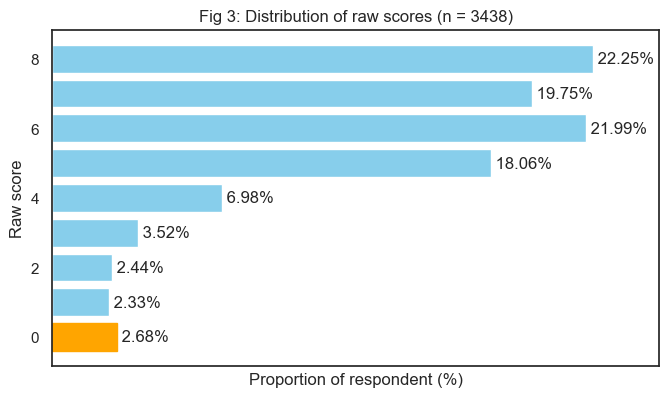

In [10]:
#Unweighted
value_count = data["fies_rawscore"].value_counts().sort_index(ascending=True)
percentage = (data["fies_rawscore"].value_counts(normalize=True) * 100).sort_index(ascending=True)

plt.figure(figsize=(7,4))
bars = plt.barh(percentage.index, percentage, color='skyblue')

# Annotating the bars with count values
for i, v in enumerate(percentage):
    plt.text(v, i, f' {percentage.values[i]:.2f}%', va='center')



# Highlighting the bar with raw score value of 0
raw_score_0_index = percentage.index.get_loc(0)
bars[raw_score_0_index].set_color('orange')  

# Adding more space around the plot
plt.tight_layout()
plt.title("Fig 3: Distribution of raw scores (n = 3438)")
plt.xlabel("Proportion of respondent (%)")
plt.ylabel("Raw score")
plt.xlim((0, 25))
plt.grid(True, axis="x")
plt.xticks([], []);


* Valid: 3438, Minimum: 0 Maximum: 8 Mean: 5.842059 Standard deviation: 1.943278
* The figure show the distribution of the raw scores in our data:
> * 2.68% respondents had a raw score of 0. They did not report any of the assessed experiences of FI. Thus, in the framework of the FIES they are considered **Food Secure**.

**Impact**

* FI is defined by a raw score higher than 0, meaning that at least one of the eight FIES questions had been answered with YES, which is the case for 97.32 % of the respondents.

#### 3.1.2 **Relationship between raw score and probability of food insecurity**

To achieve precise comparability of prevalence rates of food insecurity, we used the respondent parameter produced by the Rasch model which contains the probability of **moderate-or-severe** (`FI_mod_sev`) or **severe** (`FI_sev`) food insecurity for a respondent with each of the nine possible raw scores (0-8).

We assigned household probabilistically to classes of food insecurity severity in order to calculate rates of food insecurity at different levels of severity.


In [11]:
# Read in the data of being moderately or severely food insecure
respondent_level_probability = pd.read_csv("../data/Respondent_round_6_nigeria.csv")
respondent_level_probability.head(2)

,Raw.Score,Raw.Score.par.,Raw.Score.par.err.,Prob.mod_sev,Prob.sev,wt
0,8,2.320709,0.59951,0.999994,0.771127,0.198500
1,8,2.320709,0.59951,0.999994,0.771127,0.187787


In [12]:
# Replace dot in column names with under_score
# Remove dots at the end of column names
respondent_level_probability.columns = respondent_level_probability.columns.str.rstrip('.').str.lower()
respondent_level_probability = respondent_level_probability.rename(columns=lambda col: col.replace(".", "_"))
respondent_level_probability.head()

,raw_score,raw_score_par,raw_score_par_err,prob_mod_sev,prob_sev,wt
0,8,2.320709,0.599510,0.999994,0.771127,0.198500
1,8,2.320709,0.599510,0.999994,0.771127,0.187787
2,8,2.320709,0.599510,0.999994,0.771127,0.187787
3,8,2.320709,0.599510,0.999994,0.771127,0.198500
4,7,1.588338,0.581364,0.999459,0.310651,0.198500


In [13]:
# Merge selected columns from `response_level_probabilility columns to data dataframe
subset = respondent_level_probability[["prob_mod_sev","prob_sev"]]
fies_df = pd.concat([data, subset], axis=1)

In [14]:
# Investigate that our merge works correct
fies_df.head()

,country,state,local_govt_area,hh_agricactivity,hh_gender,hh_education,hh_size,hh_maritalstat,hh_age,resp_islsproducer,...,fcs_vegetables_days,fcs_fruit_days,fcs_meat_fish_days,fcs_dairy_days,fcs_sugar_days,fcs_oil_days,fcs_condiments_days,income_main_cat,prob_mod_sev,prob_sev
0,Nigeria,Zamfara,Talata Mafara,crop production,Male,Religious Education,18.0,2.0,41 to 65,No,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,Public employment,0.999994,0.771127
1,Nigeria,Zamfara,Bukkuyum,crop and livestock production,Male,Primary Education,9.0,2.0,41 to 65,Yes,...,7.0,0.0,0.0,0.0,0.0,3.0,3.0,Non-Agricultural wage and employment,0.999994,0.771127
2,Nigeria,Zamfara,Bukkuyum,crop and livestock production,Male,Primary Education,19.0,2.0,41 to 65,Yes,...,3.0,3.0,0.0,1.0,3.0,2.0,3.0,Production and sale of Ag produce,0.999994,0.771127
3,Nigeria,Zamfara,Talata Mafara,crop production,Male,Religious Education,14.0,2.0,41 to 65,No,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,Production and sale of Ag produce,0.999994,0.771127
4,Nigeria,Zamfara,Talata Mafara,crop production,Male,Higher Education,12.0,2.0,41 to 65,No,...,4.0,0.0,2.0,0.0,0.0,7.0,0.0,Production and sale of Ag produce,0.999459,0.310651


In [15]:
# Describe the Probability of being moderately or severely food insecure
fies_df["prob_mod_sev"].describe()

count    3438.000000
mean        0.850481
std         0.288097
min         0.000000
25%         0.891171
50%         0.991463
75%         0.999459
max         0.999994
Name: prob_mod_sev, dtype: float64

In [16]:
# Describe the  Probability of being severely food insecure
fies_df["prob_sev"].describe()

count    3438.000000
mean        0.238055
std         0.307972
min         0.000000
25%         0.000407
50%         0.022931
75%         0.310651
max         0.771127
Name: prob_sev, dtype: float64

#### 3.2 **Plot of probability of Moderate or severe FI and Probability of Severe FI (Weighted)**

In [17]:
# Melt the DataFrame
melted_df = pd.melt(fies_df, id_vars=['country', 'weight_final'], value_vars=['prob_mod_sev', 'prob_sev'], 
                    var_name='Probability_Type', value_name='Probability')

# Apply weights
melted_df['Weighted_Probability'] = melted_df['Probability'] * melted_df['weight_final']

# Calculate weighted means for each probability type
weighted_means = melted_df.groupby(['country', 'Probability_Type']).agg(Weighted_Mean=('Weighted_Probability', 'sum'),
                                                                       Total_Weight=('weight_final', 'sum'))
weighted_means['Weighted_Probability'] = weighted_means['Weighted_Mean'] / weighted_means['Total_Weight']

# Calculate weighted standard deviations for each probability type
weighted_stds = melted_df.groupby(['country', 'Probability_Type'])['Weighted_Probability'].std()

print("Prevalence standard error")
print(weighted_stds)

Prevalence standard error
country  Probability_Type
Nigeria  prob_mod_sev        1.367829
         prob_sev            0.548861
Name: Weighted_Probability, dtype: float64


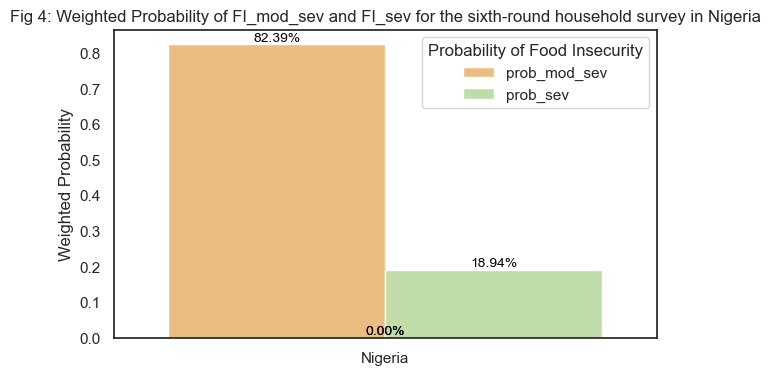

In [18]:
# Plot barplot with error bars
plt.figure(figsize=(7, 4))
sns.barplot(data=weighted_means.reset_index(), x="country", y='Weighted_Probability', hue='Probability_Type', 
            errorbar='sd', palette="Spectral", err_kws={'color': 'red', 'linewidth': 1.0})
plt.title('Fig 4: Weighted Probability of FI_mod_sev and FI_sev for the sixth-round household survey in Nigeria')
plt.xlabel('')
plt.ylabel('Weighted Probability')
plt.legend(title='Probability of Food Insecurity')
plt.yticks()

# Add annotations
for bar in plt.gca().patches:
    # Get the height of the bar
    height = bar.get_height()
    # Add the percentage text on top of the bar
    plt.gca().text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height*100:.2f}%', 
                   ha='center', color='black', fontsize=10)
    
plt.show()


#### 3.2.1 **Prevalence of Moderate or severe FI and Probability of Severe FI by state(Weighted)**

In [19]:
def fies_by_socio_demo(df, col):
    """
    Perform analysis of food insecurity by socio-demographic factors.

    Parameters:
        - df (DataFrame): The input DataFrame containing the data.
        - col (str): The column name representing the socio-demographic factor.

    Returns:
        - weighted_means (DataFrame): DataFrame containing the weighted means for
        each socio-demographic fact and probability type.
        # - weighted_stds (DataFrame): DataFrame containing the weighted standard deviations
        # for each category and probability type.
    """
    # Melt the DataFrame
    melted_df = pd.melt(
        df,
        id_vars=[col, "weight_final"],
        value_vars=["prob_mod_sev", "prob_sev"],
        var_name="Probability_Type",
        value_name="Probability",
    )

    # Calculate weighted means for each state and probability type
    weighted_means = (
        melted_df.groupby([col, "Probability_Type"])
        .agg(
            Weighted_Probability=(
                "Probability",
                lambda x: (x * melted_df.loc[x.index, "weight_final"]*100).sum()
                / melted_df.loc[x.index, "weight_final"].sum(),
            )
        )
        .reset_index()
    )

    # # Calculate weighted standard deviations for each state and probability type
    # weighted_stds = (
    #     melted_df.groupby([col, "Probability_Type"])["Probability"]
    #     .std()
    #     .reset_index(name="Weighted_Std")
    # )
    return weighted_means


In [20]:
# Utility function
def plot_fies_levels_by_variable(df, var="state", **kwargs):
    """
    Plot barplot showing the levels of food insecurity by a specified variable.

    Parameters:
    - df (DataFrame): The input DataFrame containing variable and the weighted probability of RFI.
    - var (str): The column name representing the variable to group by (default is "state").
    - **kwargs: Additional keyword arguments for customization.
        - title (str): Title of the plot.

    Returns:
    - None
    """
    # Plot barplot with error bars
    plt.figure(figsize=(10, 4))
    ax = sns.barplot(
        data=df,
        y="Probability_Type",  # Change y to Probability_Type
        x="Weighted_Probability",  # Change x to Weighted_Probability
        hue=var,
        palette="Spectral"
    )
    
    
    # Annotate each bar with the percentage value
    for i, p in enumerate(ax.patches):
        ax.text(p.get_width(), p.get_y() + \
                p.get_height() / 2, '{:.1f}%'.format(p.get_width()), 
                ha='left', va='center', fontsize=8)
    
    # Remove x-axis ticks and labels
    ax.xaxis.set_ticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.title(kwargs["title"])
    
    
    # Set y-axis tick labels after setting ticks
    ax.set_yticks(ax.get_yticks())  # Set ticks
    ax.set_yticklabels(["Moderate or severe RFI", "Severe RFI"])  # Set labels
    
    plt.legend(title=var)
    plt.show()


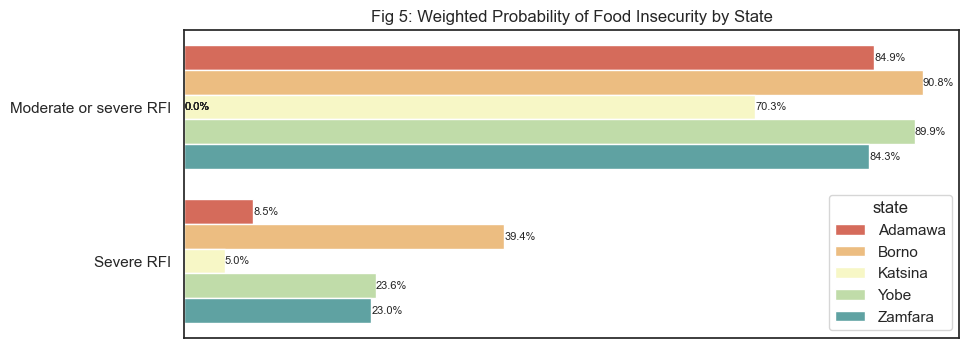

In [21]:
# Melt the DataFrame
fies_by_state = fies_by_socio_demo(fies_df, "state")
# fies_by_state
plot_fies_levels_by_variable(fies_by_state, title="Fig 5: Weighted Probability of Food Insecurity by State")

**Observation**

* According to the FIES, 82 percent of the households were affected by RFI at **moderate or severe** (`FI_mod_sev`) level, and 16.68 percent were affected by **severe** RFI (`FI_sev`).
* Borno presents the highest percentage of households affected by RFI at moderate or severe level (Figure 5) followed
closely by Yobe state.
* Katsina presents the lowest percentage of households affected by RFI at severe level (Figure 5).

**NEXT** Let create a Map of prevalence of recent moderate or severe household food insecurity (FIES) by 

In [22]:
# Load shapefile of Nigeria
file = open("../data/DIEM_household_surveys_microdata.geojson")
gdf = gpd.read_file(file)

In [23]:
gdf.head()

,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
0,Cross River,NG-CR,27671186B24287037233498,NGA,ADM1,"POLYGON ((8.27430 4.85474, 8.29153 4.84805, 8...."
1,Abuja Federal Capital Territory,NG-FC,27671186B68759235923182,NGA,ADM1,"POLYGON ((6.98081 8.44373, 6.98562 8.44342, 7...."
2,Ogun,NG-OG,27671186B80583952390127,NGA,ADM1,"POLYGON ((4.48324 6.32605, 4.48837 6.33622, 4...."
3,Oyo,NG-OY,27671186B24354382526150,NGA,ADM1,"POLYGON ((4.08836 7.13345, 4.08764 7.13805, 4...."
4,Sokoto,NG-SO,27671186B44691656482801,NGA,ADM1,"POLYGON ((4.12640 13.24967, 4.17857 13.25407, ..."


In [24]:
# Merge the shapefile with your data

merged_data = gdf.merge(fies_by_state, left_on='shapeName', right_on='state', how='right')
merged_data = merged_data.query("Probability_Type == 'prob_mod_sev'")

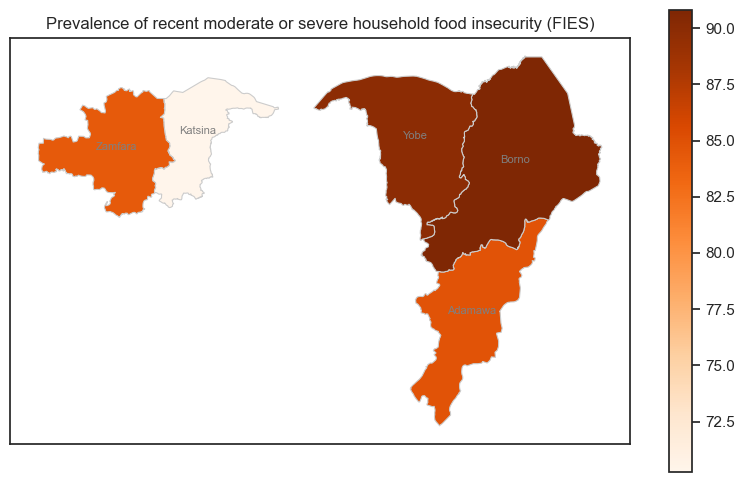

In [25]:
# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_data.plot(column="Weighted_Probability", cmap="Oranges", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)



# Annotate each state with its name
for idx, row in merged_data.iterrows():
    ax.annotate(text=row["state"], 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                color="grey", fontsize=8, ha="center")


plt.title("Prevalence of recent moderate or severe household food insecurity (FIES)")
plt.xticks([], [])
plt.yticks([], [])

plt.show()

#### 3.2.2 FIES levels by Gender

In [26]:
def fies_levels(df, probability_type="prob_mod_sev"):
    return df.query("Probability_Type == @probability_type")\
            .sort_values(by="Weighted_Probability", ascending=False)
    

Level of severe FI
  hh_gender Probability_Type  Weighted_Probability
1    Female         prob_sev             33.636877
3      Male         prob_sev             18.112127

Level of moderate or severe FI
  hh_gender Probability_Type  Weighted_Probability
0    Female     prob_mod_sev             90.905805
2      Male     prob_mod_sev             81.906436


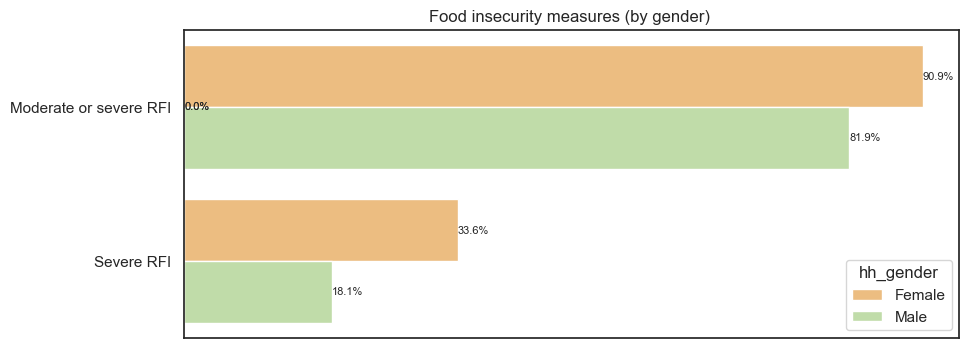

In [27]:
fies_gender = fies_by_socio_demo(fies_df, "hh_gender")

# Severe level
print("Level of severe FI")
print(fies_levels(fies_gender, probability_type="prob_sev"))

# Moderate or severe level
print("\nLevel of moderate or severe FI")

print(fies_levels(fies_gender, probability_type="prob_mod_sev"))

plot_fies_levels_by_variable(fies_gender, var="hh_gender", title="Food insecurity measures (by gender) ")

In [28]:
# Perform Kruskal-Wallis test
# Categorical independent variable `hh_education` and ordinal dependent variable.
h_statistic, p_value = kruskal(fies_df[fies_df['hh_gender'] == 'Male']['fies_rawscore'],
                                fies_df[fies_df['hh_gender'] == 'Female']['fies_rawscore'],)

# Output the results
print("Kruskal-Wallis test results:")
print("H-statistic:", h_statistic)
print("P-value:", p_value)

Kruskal-Wallis test results:
H-statistic: 16.048522253546665
P-value: 6.173979179275934e-05


In [29]:
# Perform Kruskal-Wallis test
# Categorical independent variable `hh_gender` and probability of RFI
h_statistic, p_value = kruskal(fies_df[fies_df['hh_gender'] == 'Male']['prob_sev'],
                                fies_df[fies_df['hh_gender'] == 'Female']['prob_sev'],)

# Output the results
print("Kruskal-Wallis test results:")
print("H-statistic:", h_statistic)
print("P-value:", p_value)

Kruskal-Wallis test results:
H-statistic: 16.111874700497236
P-value: 5.97084750430552e-05


**Observation**

* The level of FIES moderate or severe, and severe were higher for female-headed households compared to male-headed households and this difference is statistically significant at a p-value of 0.05


#### 3.2. FIES levels by main income source

In [30]:
fies_main_income = fies_by_socio_demo(fies_df, "income_main_cat")

# Moderate or severe level
fies_levels(fies_main_income)

,income_main_cat,Probability_Type,Weighted_Probability
4,Collection and sale of bush and wood,prob_mod_sev,88.949969
12,Production and sale of Ag produce,prob_mod_sev,84.952572
10,Non-Agricultural wage and employment,prob_mod_sev,83.520364
2,Agricultural wage and employment,prob_mod_sev,81.195307
8,No Employment,prob_mod_sev,78.357160
14,Public employment,prob_mod_sev,77.400836
6,Income not from work,prob_mod_sev,76.829237
0,Agricultural trader,prob_mod_sev,68.006176


In [31]:
# Severe level
fies_levels(fies_main_income, probability_type="prob_sev")

,income_main_cat,Probability_Type,Weighted_Probability
3,Agricultural wage and employment,prob_sev,29.406917
5,Collection and sale of bush and wood,prob_sev,27.967176
9,No Employment,prob_sev,26.874402
7,Income not from work,prob_sev,23.570455
13,Production and sale of Ag produce,prob_sev,20.342094
1,Agricultural trader,prob_sev,18.207171
15,Public employment,prob_sev,13.669029
11,Non-Agricultural wage and employment,prob_sev,13.204427


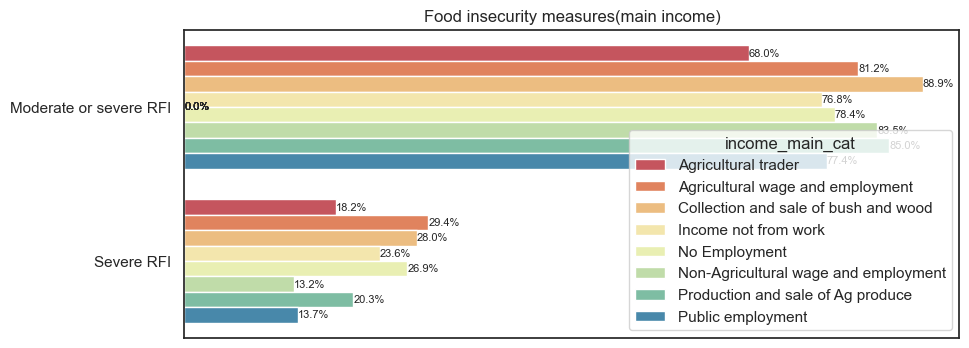

In [32]:
plot_fies_levels_by_variable(fies_main_income, var="income_main_cat", title="Food insecurity measures(main income)")

In [33]:
# Bivariate analyis between income_main_cat and FI severity level

**Oservation**
* Households whose main income source was **Collection and sale of bush and wood**, presented a higher level of FIES moderate or severe.

### 3.2 Household Demographic Characteristics
The household demographic characteristics will include the following variables
hh gender, State, education, income: source of income, agricultural activities, household size, hh age, production activities; livestocks only, crop only, ls and crop, land size


In [34]:
demo_cols = ["state","local_govt_area", "hh_agricactivity", "hh_gender",  "hh_education", 
             "hh_size", "hh_age", "income_main", "income_sec", "income_third", "income_main_cat", "income_main_comp","crp_landsize_ha",
             "resp_islsproducer", "resp_iscropproducer", "resp_isfishproducer","weight_final"]

demo_df = data.loc[:, demo_cols]


In [35]:
demo_df.head(2)

,state,local_govt_area,hh_agricactivity,hh_gender,hh_education,hh_size,hh_age,income_main,income_sec,income_third,income_main_cat,income_main_comp,crp_landsize_ha,resp_islsproducer,resp_iscropproducer,resp_isfishproducer,weight_final
0,Zamfara,Talata Mafara,crop production,Male,Religious Education,18.0,41 to 65,14.0,1.0,3.0,Public employment,5.0,4.0,No,Yes,Yes,0.198500
1,Zamfara,Bukkuyum,crop and livestock production,Male,Primary Education,9.0,41 to 65,11.0,19.0,19.0,Non-Agricultural wage and employment,1.0,1.0,Yes,Yes,No,0.187787


In [36]:
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3438 entries, 0 to 3437
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   state                3438 non-null   object 
 1   local_govt_area      3438 non-null   object 
 2   hh_agricactivity     3438 non-null   object 
 3   hh_gender            3438 non-null   object 
 4   hh_education         3438 non-null   object 
 5   hh_size              3438 non-null   float64
 6   hh_age               3438 non-null   object 
 7   income_main          3438 non-null   float64
 8   income_sec           3438 non-null   float64
 9   income_third         3438 non-null   float64
 10  income_main_cat      3438 non-null   object 
 11  income_main_comp     3438 non-null   float64
 12  crp_landsize_ha      3438 non-null   float64
 13  resp_islsproducer    3438 non-null   object 
 14  resp_iscropproducer  3438 non-null   object 
 15  resp_isfishproducer  3438 non-null   o

Upon calling `.info()` on the dataframe we can observe the following:
* There is need to transform the variables into the right data types. For instance, `hh_agricactivity`
  which is reported as an `object` should be converted to a `category` dtype. Similarly, `income_main`
  which is reported as `float` should be be categorical. We shall refer to the metadata of the dataset
  to retrieve the appropiate labelling.

In [37]:
# Convert object to categorical type
demo_df = data_type_converter(demo_df)
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3438 entries, 0 to 3437
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   state                3438 non-null   category
 1   local_govt_area      3438 non-null   category
 2   hh_agricactivity     3438 non-null   category
 3   hh_gender            3438 non-null   category
 4   hh_education         3438 non-null   category
 5   hh_size              3438 non-null   float64 
 6   hh_age               3438 non-null   category
 7   income_main          3438 non-null   float64 
 8   income_sec           3438 non-null   float64 
 9   income_third         3438 non-null   float64 
 10  income_main_cat      3438 non-null   category
 11  income_main_comp     3438 non-null   float64 
 12  crp_landsize_ha      3438 non-null   float64 
 13  resp_islsproducer    3438 non-null   category
 14  resp_iscropproducer  3438 non-null   category
 15  resp_isfishproducer  

`.info()` shows that are 7 variables that are of type `float`. For instance `income_main_comp`.
However, as we shall see, this are actually discrete variables that should be categorical.

In [38]:
# Convert float type to category
demo_df = data_type_converter(demo_df, ["hh_size", "crp_landsize_ha", "weight_final"], dtype="float64")
demo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3438 entries, 0 to 3437
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   state                3438 non-null   category
 1   local_govt_area      3438 non-null   category
 2   hh_agricactivity     3438 non-null   category
 3   hh_gender            3438 non-null   category
 4   hh_education         3438 non-null   category
 5   hh_size              3438 non-null   float64 
 6   hh_age               3438 non-null   category
 7   income_main          3438 non-null   category
 8   income_sec           3438 non-null   category
 9   income_third         3438 non-null   category
 10  income_main_cat      3438 non-null   category
 11  income_main_comp     3438 non-null   category
 12  crp_landsize_ha      3438 non-null   float64 
 13  resp_islsproducer    3438 non-null   category
 14  resp_iscropproducer  3438 non-null   category
 15  resp_isfishproducer  

#### **Household Head Age  `hh_age`**

In [39]:
demo_df["hh_age"].value_counts(normalize=False)

hh_age
41 to 65    2129
18 to 40    1247
Over 65       61
Under 18       1
Name: count, dtype: int64

Text(0.5, 1.0, 'The distribute of age in each state')

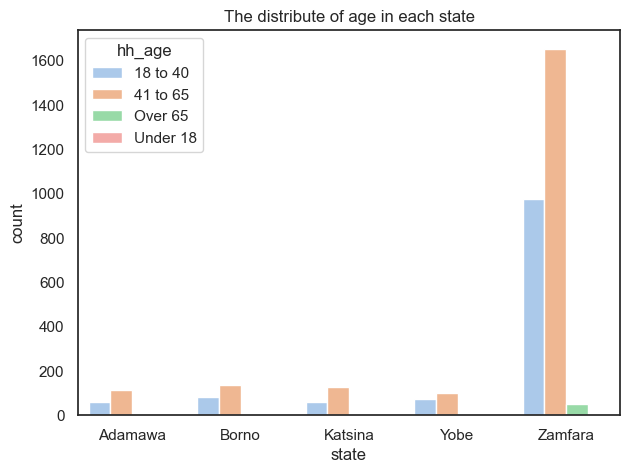

In [40]:
plt.figure(figsize=(7,5))
ax = sns.countplot(data=demo_df, x="state", hue="hh_age");
ax.set_title("The distribute of age in each state")

In [41]:
demo_df.query("hh_age == 'Under 18'")[["state", "hh_age"]]

,state,hh_age
413,Zamfara,Under 18


* Household with `hh_age` between '41 to 65' is the most prevalent across all the 5 states.
* Household with `hh_age` between `41 to 65' accounts for 62% of the case.
* There is one instance where the `hh_age` is under 18 years of age. The instance is present in Zamfara state. 

In [42]:
# Bivariate Analysis between FIES and Age. Check


#### **Household Land Size in ha  `crp_landsize_ha`**

In [43]:
demo_df.crp_landsize_ha.describe()

count    3438.000000
mean        1.889242
std         1.338200
min         0.000000
25%         1.000000
50%         1.889242
75%         2.500000
max         6.000000
Name: crp_landsize_ha, dtype: float64

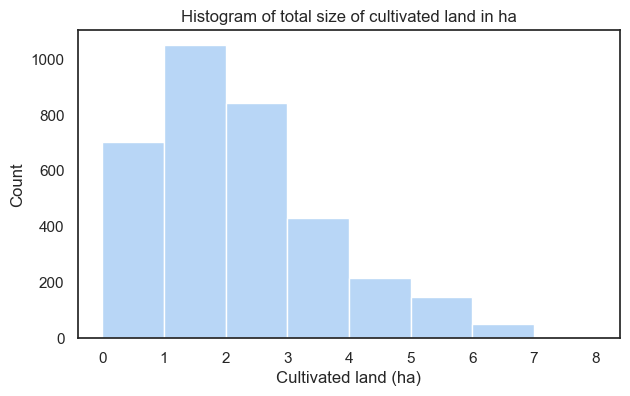

In [44]:
# Create a histogram of crp_landsize_ha
from scipy.stats import mode
plt.figure(figsize=(7,4))
sns.histplot(data=demo_df, x="crp_landsize_ha", bins=range(0, 9, 1))


ax.set_xticks(range(0, 8, 1))
ax.set_xticklabels(range(0,8,1))
plt.title("Histogram of total size of cultivated land in ha")
plt.xlabel("Cultivated land (ha)");

* The average cultivated crop landsize is between 0 ha to 3 ha.
* The mode of the cultivated crop landsize is between 1 to 2 ha.
* The average size of land in the sampled population is 1.88 ha.

In [45]:
# Household size
demo_df["hh_size"].describe()

count    3438.000000
mean       10.421522
std         4.787856
min         1.000000
25%         7.000000
50%        10.000000
75%        13.000000
max        24.000000
Name: hh_size, dtype: float64

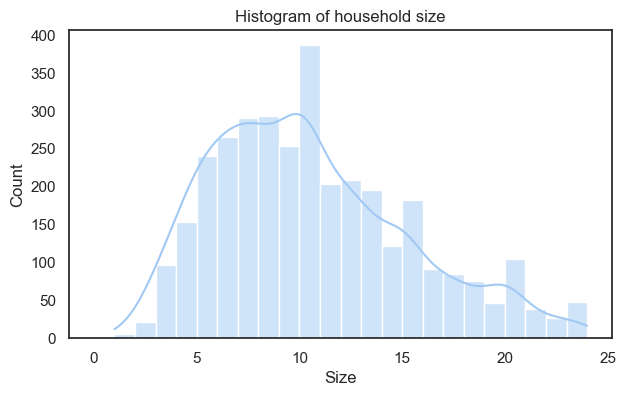

In [46]:
# Create a histogram of hh_size
plt.figure(figsize=(7,4))
sns.histplot(data=demo_df, x="hh_size", bins=range(0, 25, 1), kde=True)
ax.set_xticks(range(0, 25, 1))
ax.set_xticklabels(range(0,25,1))
plt.title("Histogram of household size")
plt.xlabel("Size");

#### **Household Head Education  `hh_education`**

In [47]:
demo_df["hh_education"].value_counts(normalize=True)

hh_education
Religious Education    0.364747
Secondary Education    0.257708
Higher Education       0.218441
Primary Education      0.114892
No Education           0.044212
Name: proportion, dtype: float64

/Users/user/Documents/Dev/Python Programming/Data Science/data_science_with_python/utils/eda.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


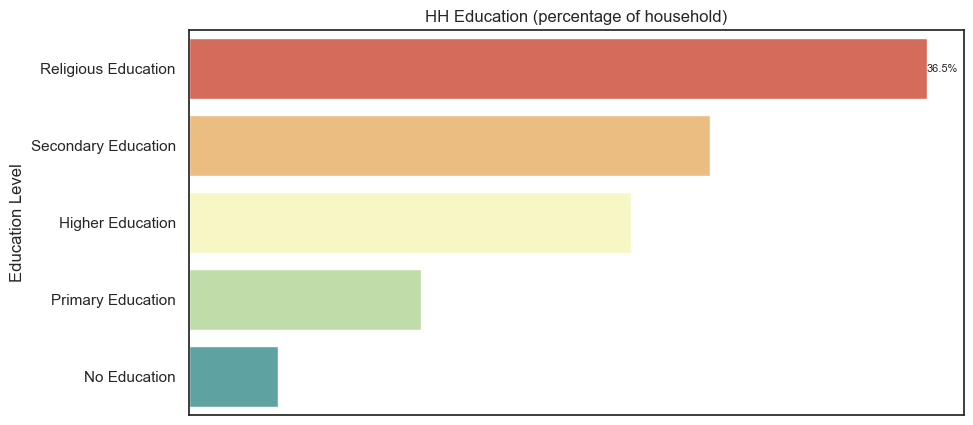

In [48]:
hh_education_grp_percent=calculate_groupby_percentage(demo_df, "hh_education")

plot_group_by_percentage(hh_education_grp_percent, 
                         "hh_education", 
                          ylabel="Education Level",
                         title="HH Education (percentage of household)")

**Bivariate analysis between `hh_education` vs `FI_mod_sev` and `FI_sev`**

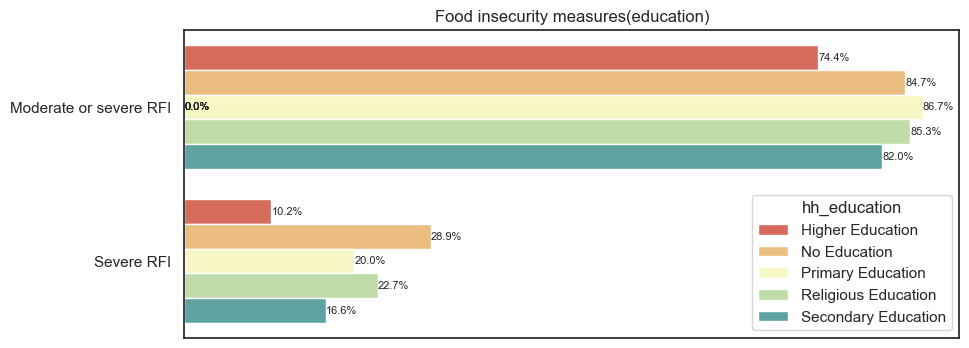

In [49]:
fies_education = fies_by_socio_demo(fies_df, "hh_education")

# # Moderate or severe level
fies_levels(fies_education)

plot_fies_levels_by_variable(fies_education, var="hh_education", 
                             title="Food insecurity measures(education)")


In [50]:

# Perform Kruskal-Wallis test
# Categorical independent variable `hh_education` and ordinal dependent variable.
h_statistic, p_value = kruskal(fies_df[fies_df['hh_education'] == 'No Education']['prob_mod_sev'],
                                fies_df[fies_df['hh_education'] == 'Primary Education']['prob_mod_sev'],
                                fies_df[fies_df['hh_education'] == 'Secondary Education']['prob_mod_sev'],
                               fies_df[fies_df['hh_education'] == 'Religious Education']['prob_mod_sev'],
                                fies_df[fies_df['hh_education'] == 'Higher Education']['prob_mod_sev'])

# Output the results
print("Kruskal-Wallis test results:")
print("H-statistic:", h_statistic)
print("P-value:", p_value)

Kruskal-Wallis test results:
H-statistic: 103.62079570061591
P-value: 1.6662860086573808e-21


* 36.4% of the household head reported to have religious or informal education only. This is form of education. 4.4% of household heads has no education or did not complete primary school.
* The level of FIES moderate or severe, and severe were lower for higher educated households compared to No education households and this difference is statistically significant.
* 

#### **Agricultural Activities `hh_agricactivity`**

In [51]:
demo_df["hh_agricactivity"].value_counts(normalize=True) * 100

hh_agricactivity
crop and livestock production    51.076207
crop production                  42.670157
livetock production               4.624782
No                                1.628854
Name: proportion, dtype: float64

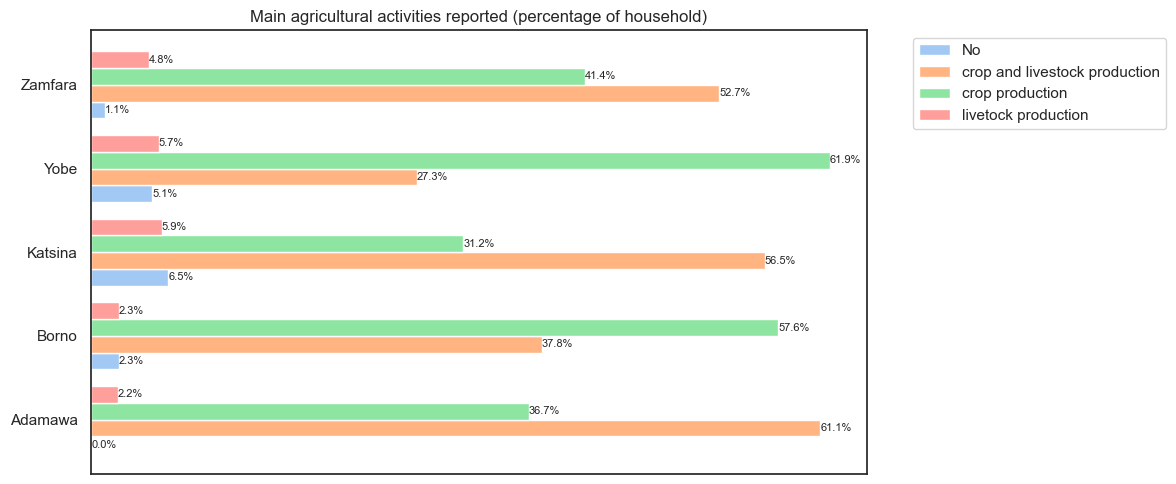

In [52]:
pivot_df_percentage_hh_agricactivity = compute_groupby(demo_df, "state", "hh_agricactivity")

plot_grouped_data(pivot_df_percentage_hh_agricactivity,stacked=False,
                  title="Main agricultural activities reported (percentage of household)", legend_title="")

**Observation**
* In terms of agricultural activities, 51.1% the households participated in both crop and livestock production. While 42.7%  and 4.6% participated in crop and livestock production respectively.
* The highest percentage of houshold participating in crop production only is in Yobe with 61.9%. Adamawa record the highest number of household engaged in both crop and livestock production (61.1%)
* 


### **Demography Income and Shock**

  - Investigate the main source of income.
  - Investigate the distribution by state.
  - Relationship between reduced income and income source
  - Investigate the most prevalent shock
  - Investigate the distribution by state.
  - _Report Main Shock reported (percentaga of household). Bar chart_


In [53]:
demo_df[["income_main"]].value_counts()

income_main
1.0            1605
3.0             332
8.0             294
4.0             277
11.0            248
14.0            178
12.0            149
19.0            112
9.0              61
13.0             53
7.0              37
2.0              32
16.0             20
5.0              10
15.0              9
10.0              8
6.0               5
17.0              4
18.0              4
Name: count, dtype: int64

According to the code book, "19.0" represents _No income source in the last 3 months and used exclusively savings, debt_

**Create a new column  `income_more_than_one`: This represents a column for houshold with more than one income.**

In [54]:
# Has more than one income
# Extract values of the three income source columns
income_values = demo_df[['income_main', "income_sec", "income_third"]].values

# check if any of the values is not 19
income_not_19 = income_values != 19.0

# Check if at least two income sources are not equal to 19
more_than_one_income = np.sum(income_not_19, axis=1) > 1

# # Map boolean values to 'Yes' or 'No'
demo_df["income_more_than_one"] = np.where(more_than_one_income, 'Yes', 'No')


In [55]:
# check the outcome
demo_df[["income_main", "income_sec", "income_third", "income_more_than_one"]].\
sort_values(by="income_main", ascending=False).head()

,income_main,income_sec,income_third,income_more_than_one
738,19.0,19.0,19.0,No
1993,19.0,19.0,19.0,No
1384,19.0,19.0,19.0,No
543,19.0,19.0,19.0,No
542,19.0,19.0,19.0,No


In [56]:
demo_df["income_more_than_one"].value_counts(normalize=True)*100

income_more_than_one
Yes    62.274578
No     37.725422
Name: proportion, dtype: float64

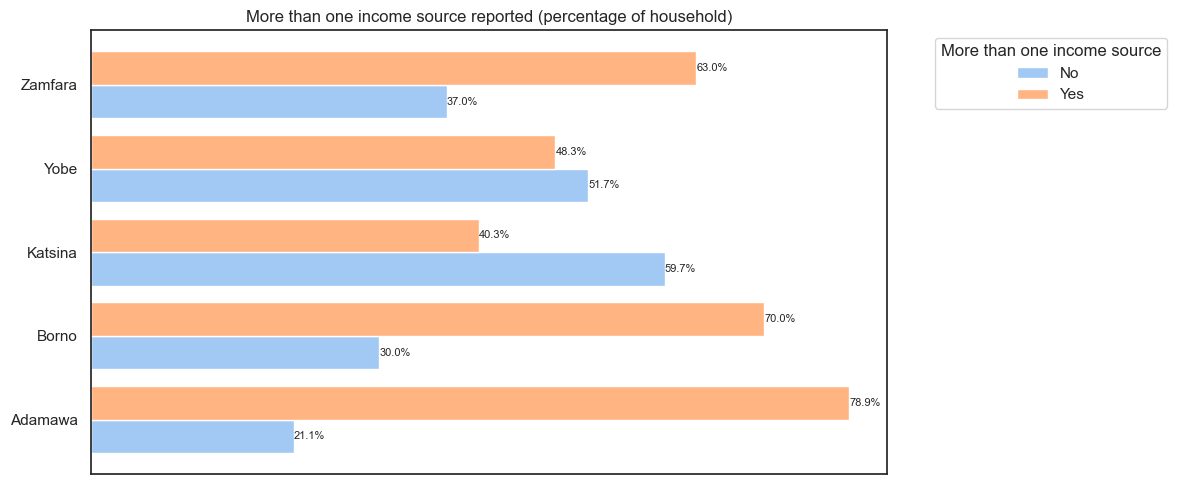

In [57]:
# Compute the pivot
pivot_df_percentage_hh_agricactivity = compute_groupby(demo_df, "state", "income_more_than_one")

# Plot the bar plot of household with more than one income by state
plot_grouped_data(pivot_df_percentage_hh_agricactivity, stacked=False,
                  title="More than one income source reported (percentage of household)",
                 xlabel="State", legend_title='More than one income source')


**Observation**
* Zamfara, Borno and Adamawa reported to have more households with more than one one source of income. With Zamfara at 78% being the highest followed closely by Borna state.
* The majority of households surveyed (62.27%) reported having engaged in more than one source of income.

How does engaging in more than one source of income relates with level of FI?


In [58]:
# Add the new variable to fies_df 

fies_df["income_more_than_one"] = demo_df["income_more_than_one"]

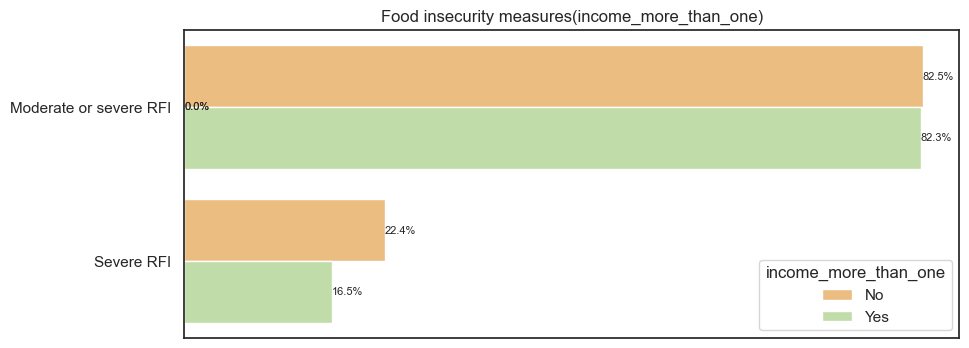

In [59]:
more_than_main_income_fies= fies_by_socio_demo(fies_df, "income_more_than_one")

# # Moderate or severe level
fies_levels(more_than_main_income_fies)

plot_fies_levels_by_variable(more_than_main_income_fies, var="income_more_than_one", 
                             title="Food insecurity measures(income_more_than_one)")


In [60]:
# Perform Kruskal-Wallis test
# Categorical independent variable `hh_gender` and probability of RFI
h_statistic, p_value = kruskal(fies_df[fies_df["income_more_than_one"] == "Yes"]['prob_mod_sev'],
                                fies_df[fies_df['income_more_than_one'] == "No"]['prob_mod_sev'],)

# Output the results
print("Kruskal-Wallis test results:")
print("H-statistic:", h_statistic)
print("P-value:", p_value)

Kruskal-Wallis test results:
H-statistic: 4.720674524668536
P-value: 0.029802050484454345


* There is no difference between the moderate or severe level of FI between respondents who engaged in more than one source of income and those who do not.

#### **Income change `income_main_comp`**

In [61]:
demo_df.income_main_comp.value_counts(normalize=True)

income_main_comp
4.0    0.383362
2.0    0.214078
5.0    0.193717
1.0    0.126527
3.0    0.082315
Name: proportion, dtype: float64

The values of of `incone_main_comp` are discrete values that ranges from 1-5:

'1' being income increase by more than 50% and '5' being income reduces by half as much.
```
{1: "A lot more",
2: "Slightly more",
3: "Same",
4: "Slightly less",
5: "A lot less"}
```

Because these values are discrete, the values shall be recoded into two groups; `increase income` and `decrease income`

In [62]:
demo_df2 = demo_df.copy()
conditions = [demo_df2["income_main_comp"].isin([1,2]), demo_df2["income_main_comp"].isin([4,5])]
choices = ['Increased', 'Decreased']
result =  pd.Categorical(np.select(conditions, choices, default="Same"))

demo_df2.insert(9, 'income_main_comp2', result)

In [63]:
# Main source of income compare
(demo_df2["income_main_comp2"].value_counts(normalize=True) * 100)

income_main_comp2
Decreased    57.70797
Increased    34.06050
Same          8.23153
Name: proportion, dtype: float64

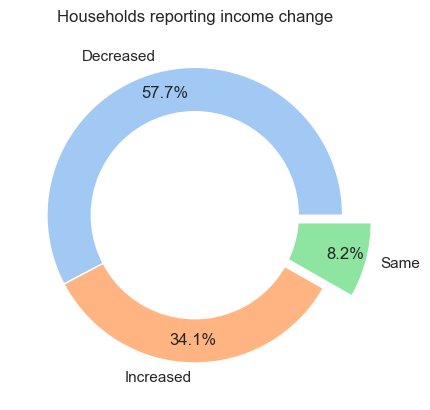

In [64]:
# Household reporting income increase
names = result.unique()
size = (demo_df2["income_main_comp2"].value_counts(normalize=True) * 100).values

# explosion
explode = (0, 0, 0.2)

# Create a circle at the center of the plot
plt.pie(size,labels=names,autopct='%1.1f%%', pctdistance=0.85, explode=explode)

my_circle = plt.Circle( (0,0), 0.7, color='white')

# Custom wedges
# plt.pie(size, labels=names, wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p = plt.gcf()
p.gca().add_artist(my_circle)
# Adding Title of chart
plt.title("Households reporting income change")
plt.show()

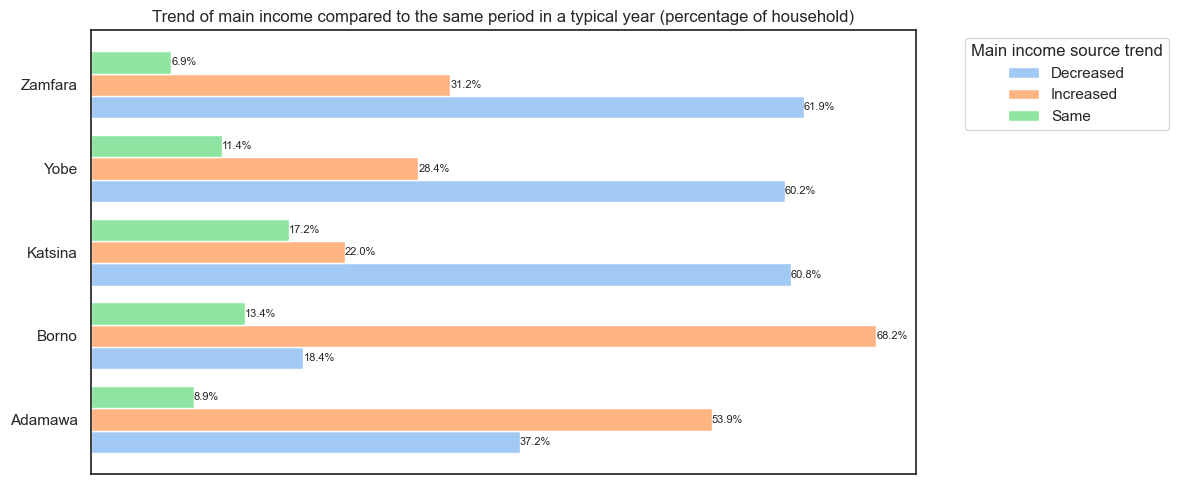

In [65]:
# Compute the pivot
pivot_df_percentage_hh_income_comp = compute_groupby(demo_df2, "state", "income_main_comp2")

# Plot the bar plot of household with more than one income by state
plot_grouped_data(pivot_df_percentage_hh_income_comp, stacked=False,
                  title="Trend of main income compared to the same period in a typical year (percentage of household)",
                 legend_title='Main income source trend')

**Observation**
* The analysis reveals that a significant proportion of households surveyed experienced a decrease in their main source of income (57.71%), while a smaller percentage reported an increase (34.06%). A minority of households indicated that their main source of income remained the same (8.23%); in the three months preceding the survey, compared to the same period in a typical year.
* A reduction in main income was experienced in Zamfara (~ 62 percent), Yobe (~ 60 percent),
and Katsina (~ 61 percent).
* Borno and Adamawa state report the highest percentage of respondents who experienced increase in their main income in the three months preceeding the survey.


What could be responsible for this increase/decrease? 
Lets conduct a bivariate analysis with landsize, harvest area, livestock number, main source of income.

#### Source of Main Income `income_main`

* What percentage of household recorded no source of income?

In [66]:
# main income source by percentage
income_grp_count=calculate_groupby_percentage(demo_df2, "income_main")
# plot_group_by_percentage(income_grp_count, 
#                          "income_main", 
#                           ylabel="Main Income Source",
#                          title="Main source of income (percentage of household)")


/Users/user/Documents/Dev/Python Programming/Data Science/data_science_with_python/utils/eda.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


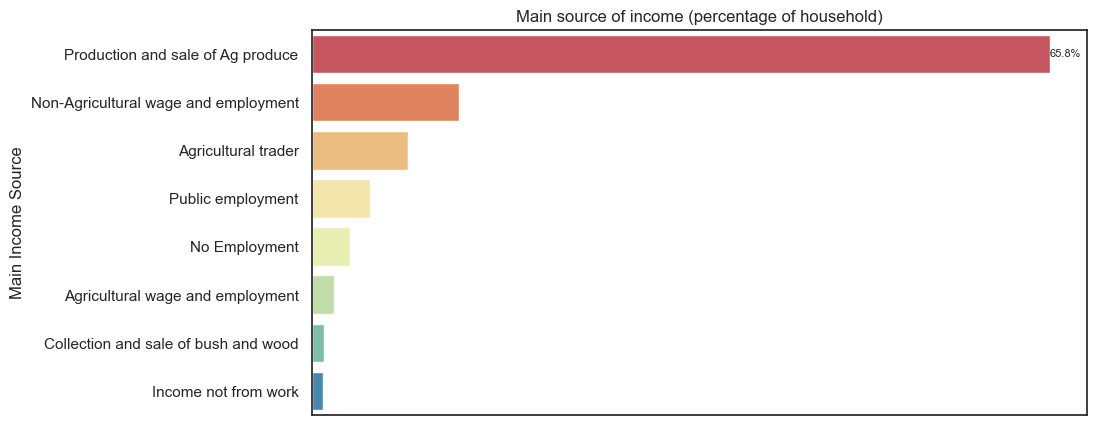

,income_main_cat,count,percentage
0,Agricultural trader,294,8.55
1,Agricultural wage and employment,69,2.01
2,Collection and sale of bush and wood,37,1.08
3,Income not from work,33,0.96
4,No Employment,116,3.37
5,Non-Agricultural wage and employment,450,13.09
6,Production and sale of Ag produce,2261,65.76
7,Public employment,178,5.18


In [67]:
# 
income_main_cat_grp_count=calculate_groupby_percentage(demo_df2, "income_main_cat")

plot_group_by_percentage(income_main_cat_grp_count, 
                         "income_main_cat", 
                          ylabel="Main Income Source",
                         title="Main source of income (percentage of household)")

income_main_cat_grp_count

**Observation**
* Sixty-six percent of the surveyed households reported 'Production and sale of agricultural produce' as their `income_main`
* Approximately 4% and 1% reported as 'Unemployed' and 'Income not from work' respectively
* 5.2% and 13.1% of the household get their income from 'Public Employment' and 'Non-Agricultural wage and employment' respectively.

**How does `income_main`(primary source of income) relates with income `income_main_comp`?**

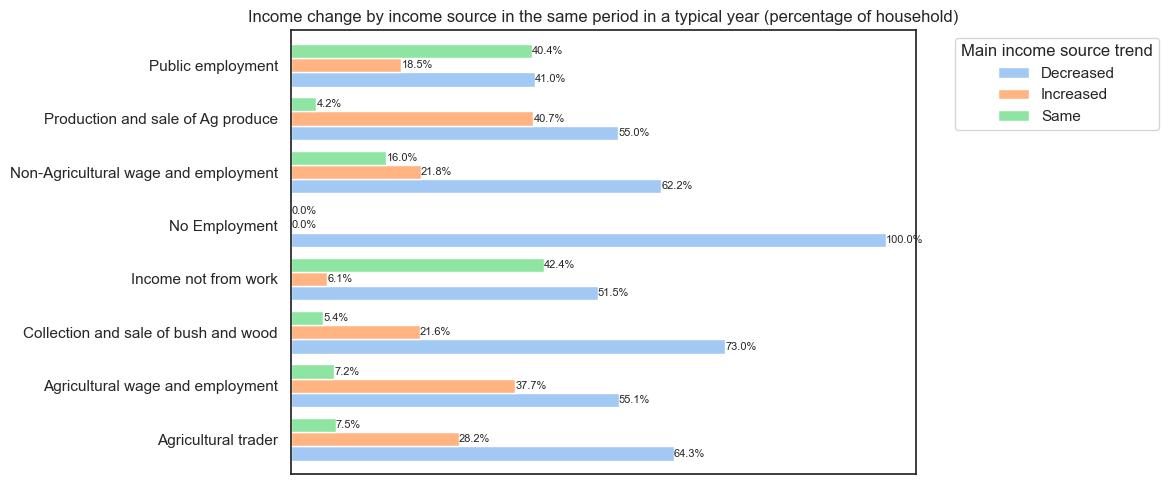

In [68]:
# Compute the pivot
percent_pivot_income_src_by_income_comp = compute_groupby(demo_df2, "income_main_cat", "income_main_comp2")

# Plot the bar plot of household with more than one income by state
plot_grouped_data(percent_pivot_income_src_by_income_comp, stacked=False,
                  title="Income change by income source in the same period in a typical year (percentage of household)",
                 legend_title='Main income source trend')

**Observation**
* Households that encountered the most notable decline in primary income, excluding those with no employment, primarily derived their income from the collection and sale of bush and wood, accounting for 73% of cases.
* 


In [69]:
# Income comp with landsize
# Income comp with hh_size
# crp_cols = [col for col in df_nig.columns if col.startswith("crp")]

### **Demography Shock**
- Household reporting shock
- What is the main reported shock?
- Main reported shock by state?
- Top ten most frequent shock
- Shock by agricultural activity

**Observation**
- Almost all household faces shock

In [142]:
#  Select columns from the DataFrame that start with "shock".
shocks_col = [col for col in data.columns if col.startswith("shock")]

# Create a DataFrame containing only columns related to specific shocks, removing non-relevant ones.
df_shock = data[shocks_col].drop(columns=["shock_noshock", "shock_dk", "shock_ref"])

df_shock.head()

,shock_sicknessordeathofhh,shock_lostemplorwork,shock_otherintrahhshock,shock_higherfoodprices,shock_higherfuelprices,shock_mvtrestrict,shock_othereconomicshock,shock_pestoutbreak,shock_plantdisease,shock_animaldisease,...,shock_hurricane,shock_drought,shock_earthquake,shock_landslides,shock_firenatural,shock_othernathazard,shock_violenceinsecconf,shock_theftofprodassets,shock_firemanmade,shock_othermanmadehazard
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Main Reported Shock**

In [161]:
# Main reported shock
def mean_percentage_main_shocks(df, n):
    # Calculate mean expressed in percentage
    mean_percentage = (df.mean() * 100).sort_values(ascending=False)
    
    # Save to a df
    main_shocks = pd.DataFrame(mean_percentage.head(n), columns=['Mean']).reset_index()
    
    # # Rename the columns for better clarity
    main_shocks.columns = ['Shock Type', 'Mean (%)']
    return main_shocks



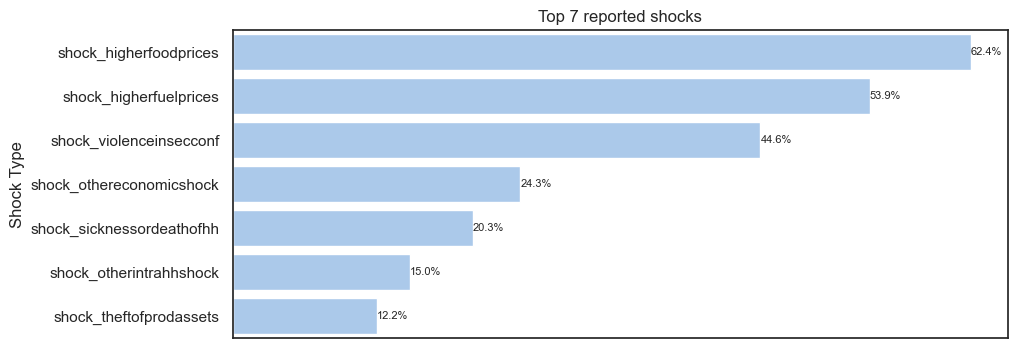

In [111]:
# Top seven main shocks
top_seven_shocks = mean_percentage_main_shocks(df_shock, 7)
# Plot

plt.figure(figsize=(10, 4))
ax = sns.barplot(top_seven_shocks, x="Mean (%)", y="Shock Type")

# Add percentage labels to the bars
ax.bar_label(ax.containers[0], fontsize=8, fmt="%1.1f%%") 

# Remove x-axis ticks and lables 
ax.xaxis.set_ticks([])
ax.set_xlabel("")
ax.set_title("Top 7 reported shocks")

plt.show();

* Ninety-nine percent of the surveyed households reported having faced at least one shock in the three months preceding the interview.
* The main reported shocks were unusually high food prices (62 percent) – followed by unusually high fuel or transport prices (53 percent).
* Shock from violence was reported by 45 percent of the surveyed houshold.
* Other economic shocks, such as inflation, have affected 24 percent of the households, followed by sickness or death of HH shocks (20 percent).
* Violence and insecurity (44.6 percent) was reported by the surveyed household.

**Overall Top Seven Main Shock by State**

In [141]:
top_seven_shocks_col = list(top_seven_shocks["Shock Type"].values)
shock_cols = list(df_shock.columns)

top_seven_shock_by_state = (fies_df.groupby(["state"])[shock_cols].mean()*100)[top_seven_shocks_col]


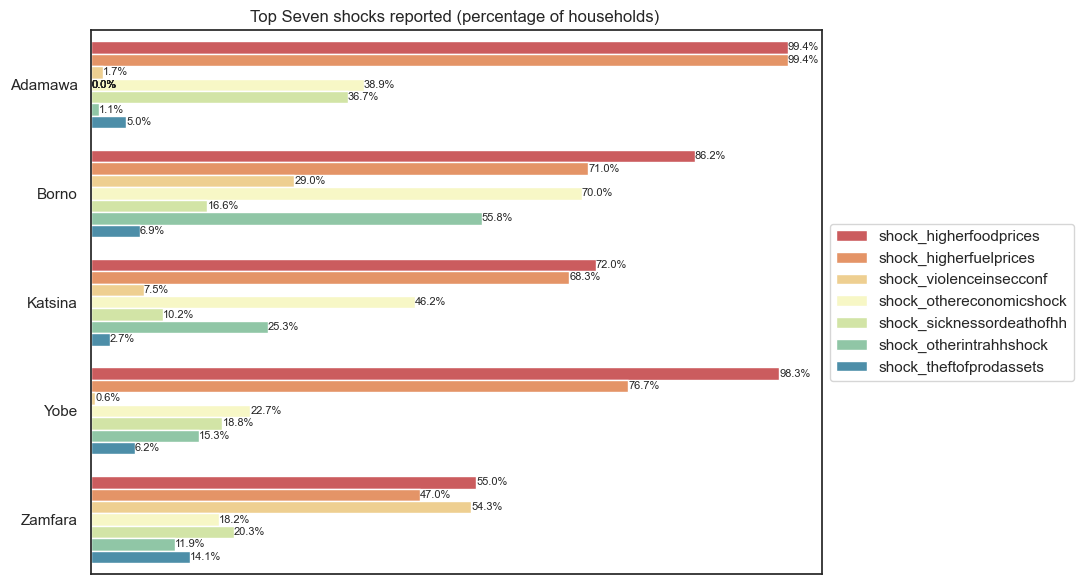

In [138]:

top_seven_shock_df_melted = top_seven_shock_by_state.reset_index().melt(id_vars='state', var_name='shock', value_name='percentage')

# Plot
plt.figure(figsize=(11, 6))
ax = sns.barplot(data=top_seven_shock_df_melted, x='percentage', y='state', hue='shock', palette="Spectral")

ax.xaxis.set_ticks([])
ax.set_xlabel("")
ax.set_ylabel("")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Top Seven shocks reported (percentage of households) ")

# Add percentage labels to the bars
# ax.bar_label(ax.containers[0], fontsize=8, fmt="%1.1f%%") 
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    y, x = p.get_xy()
    ax.annotate(
        f"{width:.1f}%", (width, x + height / 2), ha="left", va="center", fontsize=8
    )

plt.tight_layout()
plt.show()

* In Adamawa, in particular, 99.4 percent of the surveyed households experienced both higher food prices and higher fuel prices shocks.--After Adamawa, Yobe experienced the most shock from higher food prices and higher fuel prices.
* Zamfara reported the highest shock from violence and conflicts (53.4 percent) followed by Borno state (29.0 percent). Yobe experienced the least shock from violence and conflicts.
* Other economic shock such as inflation was more prevalent among the surveyed respondent in Borno (70 percent) followed by Katsina (46.2 percent)


**Climate and Agricultural Shocks**

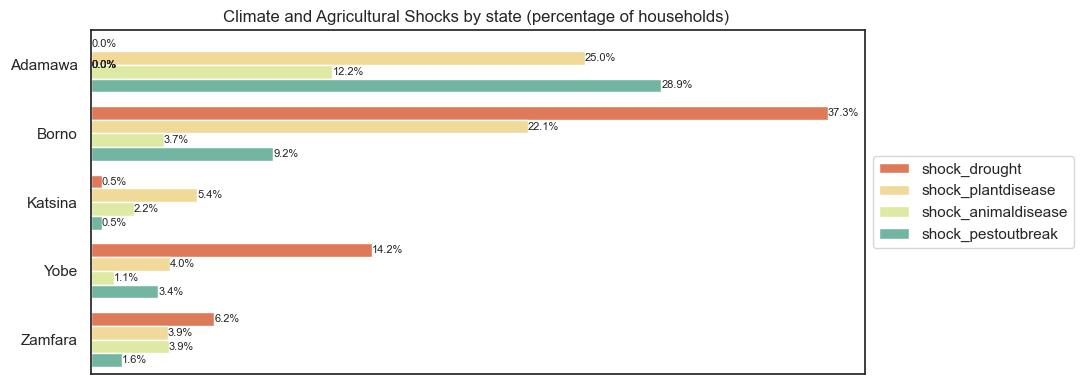

In [139]:
# List of columns representing shocks related to agriculture and climate
ag_shock_cols = ["shock_drought","shock_plantdisease", "shock_animaldisease", "shock_pestoutbreak"]

# Calculate the mean occurrence of agriculture-related shocks by state and express them as percentages.
ag_shock_by_state = (fies_df.groupby(["state"])[ag_shock_cols].mean()*100)

# Reshape the DataFrame to a 'melted' format for better visualization and analysis.
ag_shock_melted_df = ag_shock_by_state.reset_index().melt(id_vars="state", var_name="shock", value_name="percentage")

# Plot
plt.figure(figsize=(11,4))
ax = sns.barplot(data=ag_shock_melted_df, x='percentage', y='state', hue='shock', palette="Spectral")

ax.xaxis.set_ticks([])
ax.set_xlabel("")
ax.set_ylabel("")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Climate and Agricultural Shocks by state (percentage of households) ")

# Add percentage labels to the bars
# ax.bar_label(ax.containers[0], fontsize=8, fmt="%1.1f%%") 
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    y, x = p.get_xy()
    ax.annotate(
        f"{width:.1f}%", (width, x + height / 2), ha="left", va="center", fontsize=8
    )

plt.tight_layout()
plt.show()



* Shock from drought is highest in Borno followed by Yobe. No shock from drought was reported in Adamawa.
* Though no shock from drought was reported in Adamawa, it reports the highest percentage of pest ourtbreak (28.9 percent) and Plant disease (25.0 percent)
* Animal disease was mostly reported by respondent in Adawama state

**Shocks and Agricultural Activities `hh_agricactivity`**

12 most frequent shocks are associated with the agricultural activity.

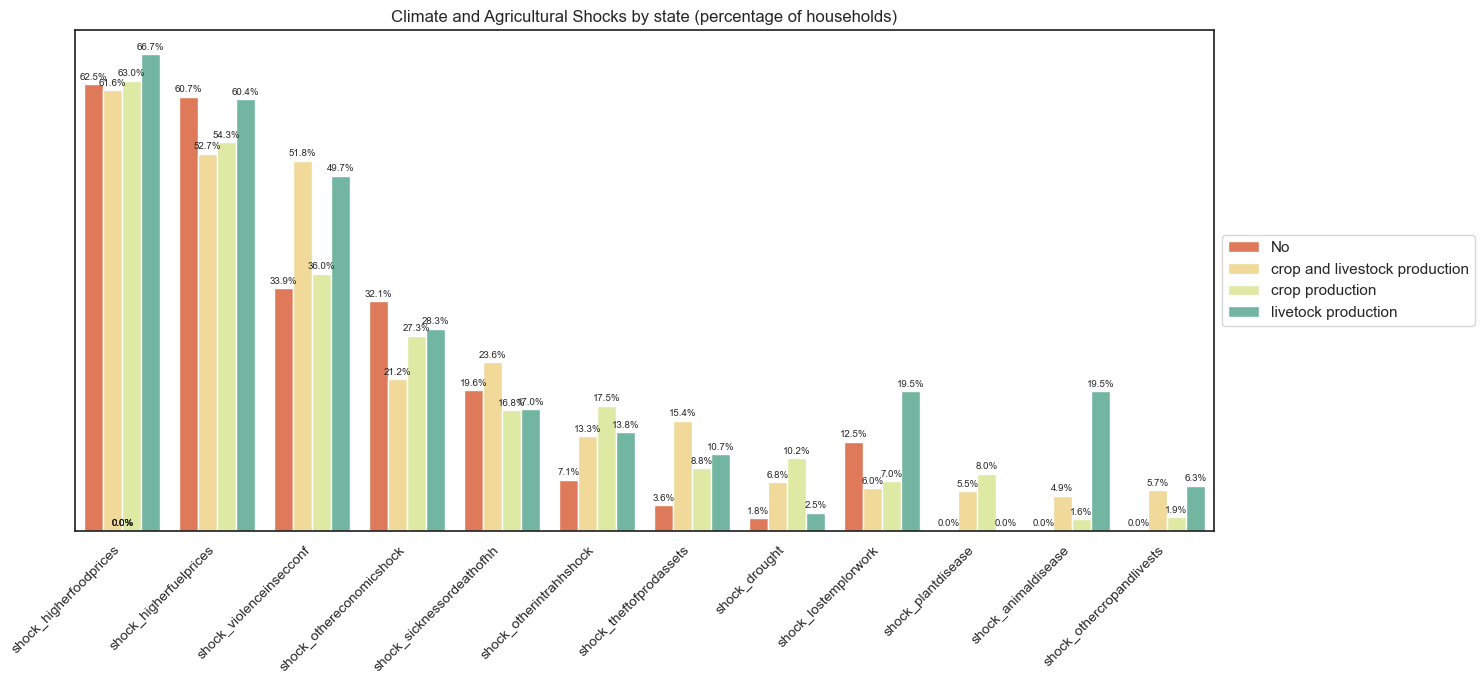

In [221]:
# 7 most frequent shocks columns

top_shocks = mean_percentage_main_shocks(df_shock, 12)
top_seven_shocks_col = list(top_shocks["Shock Type"].values)
# Calculate the mean occurrence of agriculture-related shocks by state and express them as percentages.
shock_by_ag_activities = fies_df.groupby(["hh_agricactivity"])[top_seven_shocks_col].mean() * 100

# Reshape the DataFrame to a 'melted' format for better visualization and analysis.
shock_melted_df = shock_by_ag_activities.reset_index().melt(
    id_vars="hh_agricactivity", var_name="shock", value_name="percentage"
)
# Plot the horizontal bar chart
plt.figure(figsize=(15, 7))  # Set the figure size

# Create the bar plot with x and y axes swapped
ax = sns.barplot(
    data=shock_melted_df,  # Data for the plot
    y="percentage",  # Values for the y-axis
    x="shock",  # Values for the x-axis
    hue="hh_agricactivity",  # Grouping variable
    palette="Spectral",  # Color palette
)

# Set labels and title
ax.yaxis.set_ticks([])
# ax.xaxis.set_ticks([])
plt.xticks(rotation=45, ha='right', fontsize=10)

ax.set_xlabel("")  # X-axis label
ax.set_ylabel("")  # Y-axis label
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Legend
ax.set_title("Climate and Agricultural Shocks by state (percentage of households)")  # Plot title


for bar in ax.patches:
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    ax.annotate(f"{bar.get_height():.1f}%", 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=7, xytext=(0, 5),
                   textcoords='offset points')

plt.tight_layout()  # Adjust layout
plt.show()  # Show the plot



* All the 12 most frequent shocks are associated with the agricultural activity. The shock from plant disease affected crop producing HHs the most, and, on the other hand, livestock producers was affected by animal disease the most.
* Shock from drought affected crop and livestock producing HHs.
* Irrespective of the HH agricultural activity, they all experience high shock from higher food prices and fuel prices.

## **Crop (use only crop producing household)**
  - Statistic of crop producers and by state `"resp_iscropproducer"`
  - Major crop produced by household; by state
  - Crop area and harvest area.-by state
  - R
  - HHs reporting drop in crop area planted/harvested
  - Most production difficulty experienced.-by state
  - `crp_proddiff_access_fertilzer` with target variable
  - `crp_proddiff_access_fertilzer` by state analysis
  - `crp_proddiff_access_fertilzer` and harvest area
  - `crp_proddiff_access_fertilzer` with income_comp
  - Income compare with crop and harvest area cha
  - _Report Changes in crop area (percentage of crop producers) stacked bar chart_
  - _Report Changes in harvest area (percentage of crop producers) stacked bar chart_
  - _Crop producers reporting a drop in the area planted (by state) map_
  - Sales difficulty
  - Relationship between difficulty and fies

## **Livestock**
  - Statistic of livestock producers and by state `"resp_islsproducer"`
  - Most produced livestock
  - Most production difficulty experienced
  - _Livestock production difficulties (percentage of livestock producers) barchart_ 
  - Production Difficulty by state
  - Sales difficulty by state
  - Relationship between difficulty and fies

## Summary

* The raw score ranges from 0 to 8 determined by summing the affirmative responses, which provides an **ordinal measure** of severity. However, because each application of the FIES module results in a unique scale, two individuals from different places with the same raw score may not, in fact, have a truly similar severity of food insecurity.